In [1]:
import sys,time
sys.path.append('../')
from smodels.theory.tree import Tree, InclusiveParticleNode
from smodels.theory.auxiliaryFunctions import bracketToProcessStr,flattenArray
from smodels.experiment.defaultFinalStates import finalStates
from smodels.particlesLoader import BSMList
from smodels.share.models.SMparticles import SMList
from smodels.theory.model import Model
from smodels.theory.tree import Tree
from smodels.theory.treeMatcher import TreeMatcher
from smodels.tools.physicsUnits import fb, GeV, TeV, pb
from smodels.theory.element import Element
from smodels.experiment.txnameObj import TxName, TxNameData
from smodels.experiment.infoObj import Info
from smodels.theory.auxiliaryFunctions import (elementsInStr, removeUnits, unscaleWidth,
                                               rescaleWidth, flattenArray, reshapeList,
                                               removeInclusives, addInclusives)

import networkx as nx
import numpy as np
import unum

In [2]:
filePath = '../test/database/13TeV/CMS/CMS-PAS-SUS-15-002/data/T1.txt'
globalInfo = Info('../test/database/13TeV/CMS/CMS-PAS-SUS-15-002/globalInfo.txt')
infoObj = Info('../test/database/13TeV/CMS/CMS-PAS-SUS-15-002/data/dataInfo.txt')
databaseParticles = finalStates
tx = TxName(filePath,globalInfo,infoObj,databaseParticles)

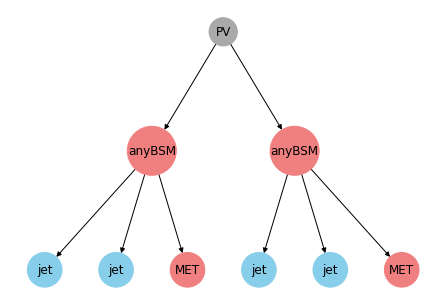

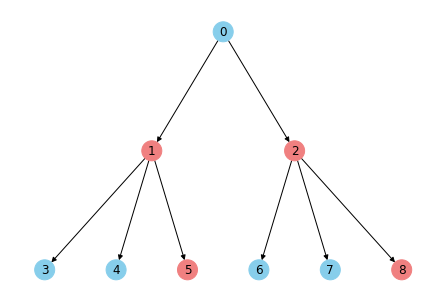

[(PV, 0), (anyBSM, 1), (anyBSM, 2), (jet, 3), (jet, 4), (MET, 5), (jet, 6), (jet, 7), (MET, 8)]


In [3]:
el = tx._topologyDict.getElements()[0]
el.drawTree()
el.drawTree(labelAttr='node')
print([(n,n.node) for n in el.tree.nodes])

In [4]:
for k in sorted(tx.dataMap.keys()):
    print(k,tx.dataMap[k])

0 (1, 'mass', 1.00E+00 [GeV])
1 (5, 'mass', 1.00E+00 [GeV])
2 (2, 'mass', 1.00E+00 [GeV])
3 (8, 'mass', 1.00E+00 [GeV])


In [5]:
for k in sorted(tx.arrayMap.keys()):
    print(k,tx.arrayMap[k])

0 ((0, 0, 0), 'mass', 1.00E+00 [GeV], 1)
1 ((0, 1, 0), 'mass', 1.00E+00 [GeV], 5)
2 ((1, 0, 0), 'mass', 1.00E+00 [GeV], 2)
3 ((1, 1, 0), 'mass', 1.00E+00 [GeV], 8)


In [6]:
print(tx.y_unit)

1.00E+00 [fb]


In [7]:
massPoint = [[100*GeV,50*GeV],[0.2*TeV,10*GeV]]
print(tx.transformPoint(massPoint))

[100.0, 50.0, 200.0, 10.0]


In [8]:
data = [ [[[100*GeV,50*GeV],[200*GeV,10*GeV]],0.1*fb],  [[[400*GeV,150*GeV],[300*GeV,30*GeV]],10.*pb]]
xvalues,yvalues = tx.transformData(data)
for ix,x in enumerate(xvalues):
    print(x,yvalues[ix])

[100.  50. 200.  10.] 0.1
[400. 150. 300.  30.] 10000.0


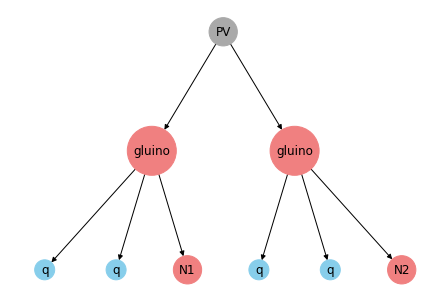

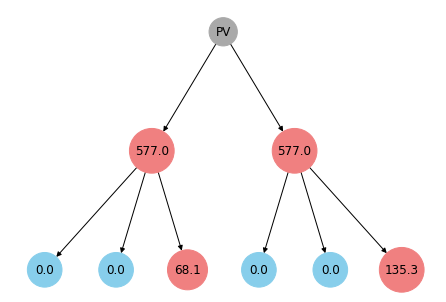

In [9]:
slhafile="../inputFiles/slha/lightEWinos.slha"
model = Model(BSMList,SMList)
model.updateParticles(inputFile=slhafile,promptWidth = 1e-12*GeV)
elB = Element("[[['u','u~']],[['d','d~']]]",model=model,
             intermediateState=[['gluino'],['gluino']],finalState=['N1','N2'])

cmp,elMatch = el.compareTo(elB)
elMatch.drawTree()
elMatch.drawTree(labelAttr='mass',attrUnit=GeV)

In [10]:
elementData = tx.getDataFromElement(elMatch)
print(elementData)
v = tx.txnameData.getValueFor(elementData)
print(v)
reweigtF = tx.getReweightingFor(elMatch)
print(reweigtF)

[577.0, 68.1, 577.0, 135.3]
None
None


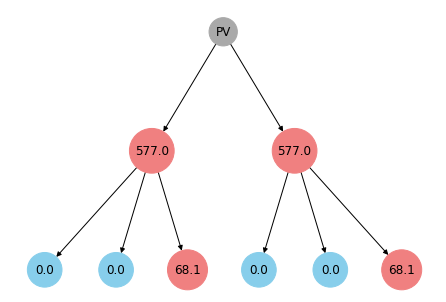

In [11]:
elB = Element("[[['u','u~']],[['d','d~']]]",model=model,
             intermediateState=[['gluino'],['gluino']],finalState=['N1','N1'])

cmp,elMatch = el.compareTo(elB)
elMatch.drawTree(labelAttr='mass',attrUnit=GeV)

In [12]:
elementData = tx.getDataFromElement(elMatch)
print(elementData)
v = tx.txnameData.getValueFor(elementData)
print(v)
reweigtF = tx.getReweightingFor(elMatch)
print(reweigtF)

[577.0, 68.1, 577.0, 68.1]
None
1.0


In [13]:
elementData = [650.,203.,650.,203.]
v = tx.txnameData.getValueFor(elementData)
print(v,'(expected  ~ 196)') # expected ~ 196
# Change gluino and neutralino masses to get a result:
gluino = model.getParticlesWith(label='gluino')[0]
N1 = model.getParticlesWith(label='N1')[0]
gluino.mass = 650*GeV
N1.mass = 203*GeV
v = tx.getULFor(elMatch)
print(v)

195.80784087494462 (expected  ~ 196)
1.96E+02 [fb]


In [14]:
p = tx.txnameData.PCAtransf(elementData)
# print(p)
pInv = tx.txnameData.inversePCAtransf(p)
pInv = [tx.txnameData.round_to_n(x,5) for x in pInv[:]]
print(pInv)
print(pInv == elementData)

[650.0, 203.0, 650.0, 203.0]
True


In [15]:
print(tx.inverseTransformPoint(elementData))

[[6.50E+02 [GeV], 2.03E+02 [GeV]], [6.50E+02 [GeV], 2.03E+02 [GeV]]]


In [16]:
# Check reweighting
# Change gluino and neutralino widths:
gluino.totalwidth = 1e-13*GeV
N1.totalwidth = 1e-20*GeV
Leff_inner = 0.000769
Leff_outer = 7.0
hc = 197.327*1e-18
Flong = (np.exp(-N1.totalwidth.asNumber(GeV)*Leff_outer/hc))**2
Fprompt = (1. - np.exp(-gluino.totalwidth.asNumber(GeV)*Leff_inner/hc))**2
rFexp = 1/(Flong*Fprompt)
rF = tx.getReweightingFor(elMatch)
print(rF,'(expected ~ %1.2f)' %rFexp)
ul = tx.getULFor(elMatch)
print(ul,'(expected 195*9.6 ~1870)')

9.60698662693211 (expected ~ 9.61)
1.88E+03 [fb] (expected 195*9.6 ~1870)
